In [2]:
from openai import OpenAI
import json
import os

In [25]:
# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Create an assistant
assistant = client.beta.assistants.create(
    name="Creative Assistant",
    instructions="You are a helpful assistant that can generate quotes and images. When asked for an image, use the generate_image function. When asked for a quote, use the generate_quote_from_prompt function.",
    model="gpt-4o",
    tools=[{
        "type": "function",
        "function": {
            "name": "generate_quote_from_prompt",
            "description": "Generate an inspirational quote based on a given theme or topic",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The theme or topic for the quote"
                    }
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Generate an image using DALL-E based on a text description",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The text description of the image to generate"
                    },
                    "size": {
                        "type": "string",
                        "enum": ["1024x1024", "1792x1024", "1024x1792"],
                        "description": "Size of the image"
                    },
                    "quality": {
                        "type": "string",
                        "enum": ["standard", "hd"],
                        "description": "Quality of the image"
                    }
                },
                "required": ["prompt"]
            }
        }
    }]
)



In [12]:
from openai import OpenAI
from IPython.display import Image, display
from io import BytesIO
import requests

def generate_image(prompt: str, size: str = "1024x1024", quality: str = "standard"):
    """
    Generate an image using DALL-E based on a text prompt.
    
    Args:
        prompt (str): The text description of the image to generate
        size (str): Size of the image. Options: "1024x1024", "1792x1024", or "1024x1792"
        quality (str): Quality of the image. Options: "standard" or "hd"
    
    Returns:
        BytesIO: The generated image as a BytesIO object
    """
    try:
        
        # Generate image
        response = client.images.generate(
            model="dall-e-3",
            prompt=prompt,
            size=size,
            quality=quality,
            n=1,
        )
        
        # Get image URL
        image_url = response.data[0].url
        
        # Download the image
        image_response = requests.get(image_url)
        image_data = BytesIO(image_response.content)
        
        # Display the image in notebook
        display(Image(data=image_data.getvalue()))
        
        return image_data
        
    except Exception as e:
        print(f"Error generating image: {str(e)}")
        return None

# Example usage:
# generated_image = generate_image("A cute robot painting a sunset")

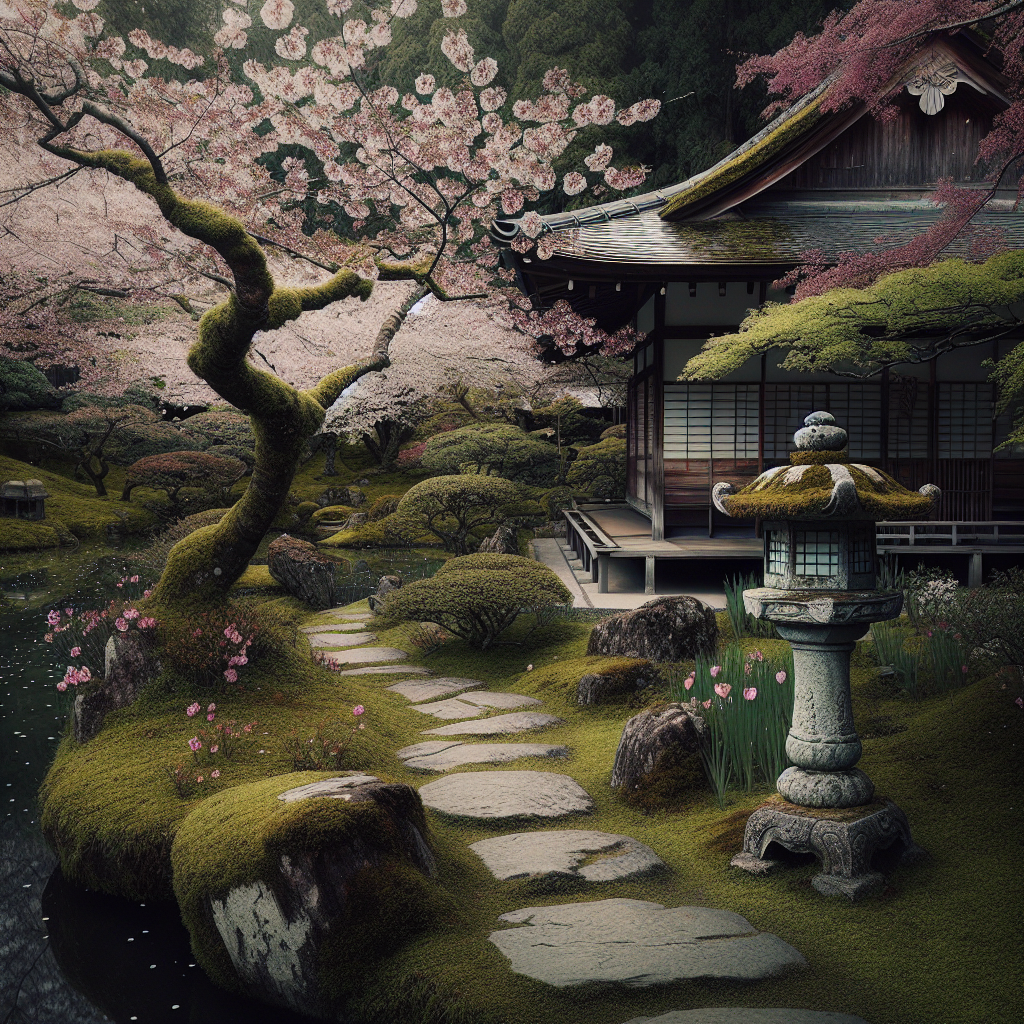

In [13]:
# Generate a single image
image_data = generate_image(
    prompt="A serene Japanese garden with cherry blossoms",
    size="1024x1024",  # Options: "1024x1024", "1792x1024", or "1024x1792"
    quality="standard" # Options: "standard" or "hd"
)

# # If you need to save the image:
# if image_data:
#     with open("generated_image.png", "wb") as f:
#         f.write(image_data.getvalue())

In [22]:
from openai import OpenAI
import os

# Initialize OpenAI client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

def generate_quote_from_prompt(prompt: str):
    """
    Generate a quote based on the user's prompt using OpenAI's model.
    
    Args:
        prompt (str): The user's prompt or theme for the quote.
        
    Returns:
        str: A generated quote related to the prompt.
    """
    try:
        # Create a completion request to generate a quote
        response = client.chat.completions.create(
            model="gpt-4",  # You can use "gpt-3.5-turbo" or other models as needed
            messages=[
                {"role": "user", "content": f"Generate a quote about: {prompt}"}
            ],
            max_tokens=50,  # Limit the length of the quote
            n=1,
            stop=None,
            temperature=0.7  # Adjust creativity level
        )
        
        # Extract the generated quote from the response
        quote = response.choices[0].message.content.strip()
        return quote
    
    except Exception as e:
        print(f"Error generating quote: {str(e)}")
        return "Could not generate a quote at this time."

# Example usage:
# print(generate_quote_from_prompt("inspiration"))
# print(generate_quote_from_prompt("life"))
# print(generate_quote_from_prompt("success"))

In [23]:
print(generate_quote_from_prompt("how to be a good person"))


"Being a good person doesn't mean perfection; it means practicing kindness, understanding, and integrity, even when they are not convenient or easy."


In [26]:
# Store threads for each user
user_threads = {}

def chat(user_id: str, message: str):
    """
    Handle a chat message from a user.
    
    Args:
        user_id: Unique identifier for the user
        message: The user's message
    
    Returns:
        dict: The assistant's response
    """
    # Get or create thread for this user
    if user_id not in user_threads:
        user_threads[user_id] = client.beta.threads.create()
    
    thread = user_threads[user_id]
    
    # Add the user's message to the thread
    client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )
    
    # Run the assistant on the thread
    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id
    )
    
    # Wait for the run to complete
    while run.status in ["queued", "in_progress"]:
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id
        )
        
        # Handle function calls if required
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            tool_outputs = []
            
            for tool_call in tool_calls:
                function_name = tool_call.function.name
                function_args = json.loads(tool_call.function.arguments)
                
                if function_name == "generate_quote_from_prompt":
                    output = generate_quote_from_prompt(function_args["prompt"])
                elif function_name == "generate_image":
                    image_data = generate_image(
                        prompt=function_args["prompt"],
                        size=function_args.get("size", "1024x1024"),
                        quality=function_args.get("quality", "standard")
                    )
                    # Return the image URL for display
                    output = "Image generated successfully"
                
                tool_outputs.append({
                    "tool_call_id": tool_call.id,
                    "output": output
                })
            
            # Submit tool outputs back to the assistant
            run = client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id,
                run_id=run.id,
                tool_outputs=tool_outputs
            )
    
    # Get the assistant's response
    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )
    
    # Return the latest assistant message
    for msg in messages:
        if msg.role == "assistant":
            return {
                "response": msg.content[0].text.value,
                "thread_id": thread.id
            }
    
    return {"error": "No response generated"}

In [ ]:
from IPython.display import display, clear_output
import ipywidgets as widgets

def create_chat_ui():
    # Create input widget
    text_input = widgets.Text(
        placeholder='Type your message here...',
        description='You:',
        layout=widgets.Layout(width='80%')
    )
    output = widgets.Output()
    
    def on_submit(b):
        message = text_input.value
        text_input.value = ''  # Clear input
        
        # Disable input while processing
        text_input.disabled = True
        text_input.placeholder = 'Waiting for response...'
        
        with output:
            if message.lower() in ['exit', 'quit', 'bye']:
                print("\nChat ended.")
                return
                
            print(f"\nYou: {message}")
            response = chat("user_123", message)
            print(f"\nAssistant: {response['response']}")
        
        # Re-enable input after response
        text_input.disabled = False
        text_input.placeholder = 'Type your message here...'
    
    text_input.on_submit(on_submit)
    
    # Display the UI elements
    display(text_input, output)

# Create and display the chat interface
create_chat_ui()

C:\Users\Asus\AppData\Local\Temp\ipykernel_35848\140752556.py:34: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  text_input.on_submit(on_submit)


Text(value='', description='You:', layout=Layout(width='80%'), placeholder='Type your message here...')

Output()